Notebook for comparing the outputted beta values under different MVN samplers

TODO refactor for multiple runs

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# OUTPUTS_DIR = 'output/aug4benchmarking/'
OUTPUTS_DIR = 'output/aug10benchmarking/'

In [3]:
CONTROL_OUTPUTS_DIR = 'output/aug10problemgeneration/' # to sanity check, these samples were generated by changing the beta generation algorithm to sample from MVN(mean, Ident) — so the variance is all wrong

In [3]:
def process_filename(filename):
    """Quick function to process a filename; coded up specific to the experiment run on Aug 3/4"""
    sampler_type = filename.split('_')[1]
    n_max_iterations = None
    if 'maxCGMiters' in filename:
        n_max_iterations = filename.split('maxCGMiters=')[1].split('_')[0] # extremely hacky but it works
    return sampler_type, n_max_iterations

def parse_SNP_file(filepath):
    with open(filepath) as f:
        reader = csv.reader(f, delimiter='\t')

        effect_vector = []
        for line in reader:
            # TODO I believe the SNPs are always outputted in the same order, but as a sanity check we should probably do something with the IDs
            effect_size = line[-1]
            effect_size = float(effect_size)
            effect_vector.append(effect_size)
        # effect_vector = np.array(effect_vector)
    return effect_vector

In [4]:
sampler_to_effect_vectors = {}

for filename in os.listdir(OUTPUTS_DIR):
    sampler_type, n_max_iterations = process_filename(filename)

    sampler_name = sampler_type
    if 'cgm' in sampler_type:
        sampler_name += '_maxCGMiters=' + n_max_iterations

    filepath = os.path.join(OUTPUTS_DIR, filename)
    effect_vector = parse_SNP_file(filepath)

    if sampler_name not in sampler_to_effect_vectors:
        sampler_to_effect_vectors[sampler_name] = []
    sampler_to_effect_vectors[sampler_name].append(effect_vector)

for sampler_name, samples in sampler_to_effect_vectors.items():
    sampler_to_effect_vectors[sampler_name] = np.array(samples)


In [13]:
control_samples = []
for filename in os.listdir(CONTROL_OUTPUTS_DIR):
    filepath = os.path.join(CONTROL_OUTPUTS_DIR, filename)
    effect_vector = parse_SNP_file(filepath)
    control_samples.append(effect_vector)
sampler_to_effect_vectors['control'] = np.array(control_samples)

In [5]:
sampler_to_effect_vectors.keys()

dict_keys(['precondcgm_maxCGMiters=10', 'precondcgm_maxCGMiters=9', 'precondcgm_maxCGMiters=1', 'precondcgm_maxCGMiters=8', 'precondcgm_maxCGMiters=3', 'precondcgm_maxCGMiters=6', 'precondcgm_maxCGMiters=5', 'vanilla', 'precondcgm_maxCGMiters=2', 'precondcgm_maxCGMiters=7', 'precondcgm_maxCGMiters=4'])

In [6]:
sampler_to_effect_vectors['vanilla'].shape

(10, 1000)

In [7]:
def calculate_correlations_to_baseline_run(sampler_to_effect_vector, baseline_run_id):
    baseline_vector = sampler_to_effect_vector['vanilla'][baseline_run_id]

    sampler_to_correlations = {}

    for sampler, effect_vectors in sampler_to_effect_vector.items():
        correlations = [np.corrcoef(baseline_vector, effect_vectors[i])[0,1] for i in range(effect_vectors.shape[0])]
        # correlation = np.corrcoef(baseline_vector, experimental_vector)[0,1] # the off-diagonal value
        sampler_to_correlations[sampler] = correlations
    return sampler_to_correlations

In [8]:
BASELINE_VECTOR_ID = 2

sampler_to_correlations = calculate_correlations_to_baseline_run(sampler_to_effect_vectors, BASELINE_VECTOR_ID)

In [9]:
# for sampler_type, correlations in sampler_to_correlations.items():
#     print(f'{sampler_type} has average correlation {np.average(correlations)}')

In [15]:
np.max(sampler_to_correlations['vanilla'][0:0])

ValueError: zero-size array to reduction operation maximum which has no identity

Text(0.5, 1.0, 'Average correlations by max # of CGM iterations')

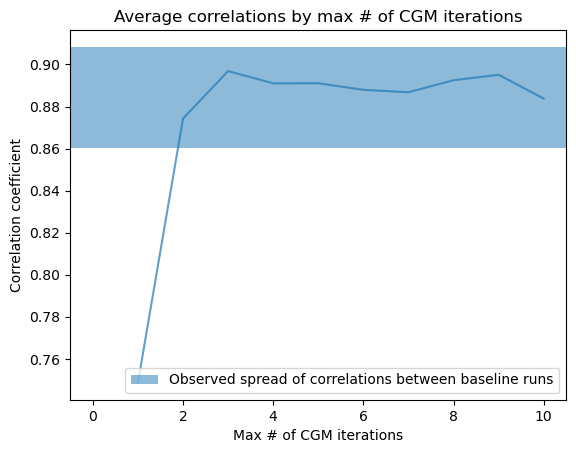

In [49]:
# we will cycle through each possible baseline run and simultaneously
#    1. calculate the average variation in correlations one can expect to see with baseline runs against other baseline runs
#    2. calculate, for any fixed baseline run, the average correlation between that particular run and each of the n-iters runs
# the resulting plot will therefore be: for each of the baseline runs, some line plot showing how correlation changes with the number of iterations; and then, overlaid upon the plot, a band showing the typical range of correlations that baseline runs are expected to have against themselves.
# One would interpret this plot by seeing whether and when runs with particular # of iterations achieve a correlation sufficiently high to be comparable to if native PRScs were used.

fig, ax = plt.subplots()

min_baseline_self_correlation = 1
max_baseline_self_correlation = -1

# for i in range(0, 10):
for i in [9]:
    sampler_to_correlations = calculate_correlations_to_baseline_run(sampler_to_effect_vectors, i)
    average_correlations = [np.average(sampler_to_correlations[f'precondcgm_maxCGMiters={x}']) for x in range(1,11)]

    # plot the correlations against run `i`
    ax.plot(range(1,11), average_correlations,
            # label=f"Average correlation coefficient against baseline run {i}",
            alpha=0.7)

    min_baseline_self_correlation = np.min([np.min(sampler_to_correlations['vanilla']),
                                          min_baseline_self_correlation])
    
    # unbelievably cursed way of computing this, but I don't want to mess around with the fancier slicing techniques to exclude index `i` (which will always have a correlation of 1.0 with itself, of course)
    max_baseline_self_correlation = np.max([np.max(sampler_to_correlations['vanilla'], where=[j != i for j in range(0, 10)], initial=-1),
                                          max_baseline_self_correlation])

# plot the max/min correlations between baseline runs
# TODO use color to add this to the legend
# TODO would it make more sense to instead provide an average self-correlation value for each run?
ax.fill_between([0, 1], min_baseline_self_correlation, max_baseline_self_correlation,
                alpha=0.5,
                transform=ax.get_yaxis_transform(),
                label="Observed spread of correlations between baseline runs")
ax.set_xlabel("Max # of CGM iterations")
ax.set_ylabel("Correlation coefficient")
ax.legend(loc='lower right')
ax.set_title("Average correlations by max # of CGM iterations")

In [12]:
# this is no longer necessary now that we have multiple baseline runs and can calculate the correlation against each other
OTHER_BASELINE_RUN = 'output/aug3benchmarking1/2023-08-03T19:15:55Z_vanilla_exact_pst_eff_a1_b0.5_phi1e-02_chr22.txt'
with open(OTHER_BASELINE_RUN) as f:
    reader = csv.reader(f, delimiter='\t')

    baseline2_effect_vector = []
    for line in reader:
        # TODO I believe the SNPs are always outputted in the same order, but as a sanity check we should probably do something with the IDs
        effect_size = line[-1]
        effect_size = float(effect_size)
        baseline2_effect_vector.append(effect_size)
    baseline2_effect_vector = np.array(baseline2_effect_vector)

In [8]:
def plot_diagonal_vectors(v1, v2, v1_name, v2_name, title=None):
    """Generates a diagonal plot comparing two effect vectors `v1, v2`"""

    fig, ax = plt.subplots()
    plt.suptitle(title, fontsize=12, y=1)
    plt.title(f"Pearson correlation coefficient = {np.corrcoef(v1, v2)[0,1]:.3f}", fontsize=12)
    plt.xlabel(v1_name)
    plt.ylabel(v2_name)
    lims = [
        np.min([v1.min(), v2.min()]),
        np.max([v1.max(), v2.max()])
    ]
    ax.plot(lims, lims, color="gray")
    ax.axline((0, 0), slope=1.0, color='k')
    ax.set_aspect('equal', adjustable='box') 
    plt.plot(v1, v2,'.', markersize=4)

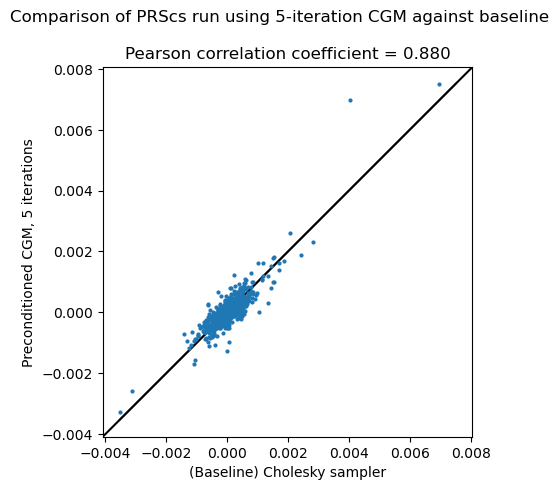

In [10]:
n_iters = 5
cgm_filename = f'precondcgm_maxCGMiters={n_iters}'
plot_diagonal_vectors(baseline_vector, sampler_to_effect_vectors[cgm_filename], '(Baseline) Cholesky sampler', f'Preconditioned CGM, {n_iters} iterations', f'Comparison of PRScs run using {n_iters}-iteration CGM against baseline')

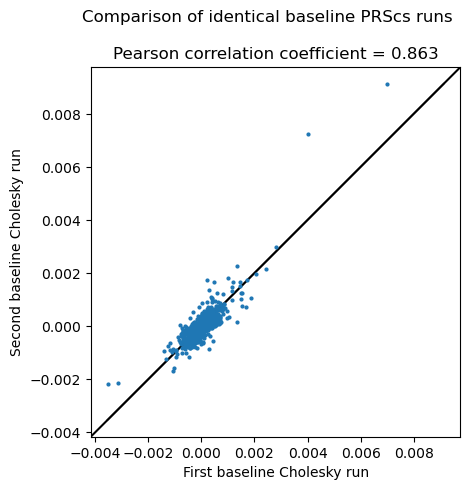

In [17]:
plot_diagonal_vectors(baseline_vector, baseline2_effect_vector, 'First baseline Cholesky run', 'Second baseline Cholesky run', 'Comparison of identical baseline PRScs runs')